In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

from MEM_class import MEM

from synthData_Gen import SyntheticData_Gen

Define depth and signal data from synthetic data. Create an instance of a signal to use for spectral analysis.

In [53]:
milcent = pd.read_csv('../Data/datasets/Milcent/milcent1973detail.txt', ',')[1:]

crete = pd.read_csv('../Data/datasets/Alphabet_cores/crete_det.txt',' ')[1:]

SiteA = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteA_det.txt', ' ')[1:]
SiteB = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteB_det.txt', ' ')[1:]
SiteD = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteD_det.txt', ',')[1:]
SiteE = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteE_det.txt', ' ')[1:]
SiteF = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteF_det.txt', ',')[1:]
SiteG = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteG_det.txt', ' ')[1:]
SiteH = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteH_det.txt', ',')[1:]

B19 = pd.read_csv('../Data/datasets/B_cores_AWI/AWI_Bcores__Cleaned_CSV/Depth_d18O__B19.txt', '\t')
B22 = pd.read_csv('../Data/datasets/B_cores_AWI/AWI_Bcores__Cleaned_CSV/Depth_d18O__B22.txt', '\t')
B23 = pd.read_csv('../Data/datasets/B_cores_AWI/AWI_Bcores__Cleaned_CSV/Depth_d18O__B23.txt', '\t')


#AllData = {'milcent': milcent, 'crete': crete, 'SiteA': SiteA, 'SiteB': SiteB, 'SiteD': SiteD, \
#          'SiteE': SiteE, 'SiteF': SiteF, 'SiteG': SiteG, 'SiteH': SiteH, 'B19': B19, 'B22': B22, 'B23': B23}

AllData = {'crete': crete, 'SiteA': SiteA, 'SiteB': SiteB, 'SiteD': SiteD, \
          'SiteE': SiteE, 'SiteG': SiteG, 'B19': B19, 'B22': B22, 'B23': B23}

CoreNames = ['crete','SiteA','SiteB','SiteD','SiteE','SiteG','B19','B22','B23']
CoreColors = ['slategray','indianred', 'orangered','darkslategray', 'slategray', 'cadetblue', 'darkseagreen', 'tan', 'rosybrown']

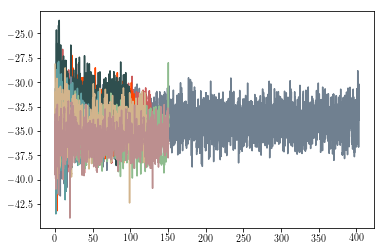

In [54]:
for core, col in zip(CoreNames, CoreColors):
    plt.plot(AllData[core]['depth'], AllData[core]['d18O'], color=col)

Compute a new depth array with evenly spaced entries. New sampling size corresponds to smallest sample size in examined series.

In [55]:
valsMin = [64.70, 70.90, 73.00, 81.50, 53.40, 60.50, 32.58, 45.44, 39.48]
valsMax = [74.74, 80.85, 83.70, 93.80, 62.95, 69.40,37.12, 52.04, 45.38]

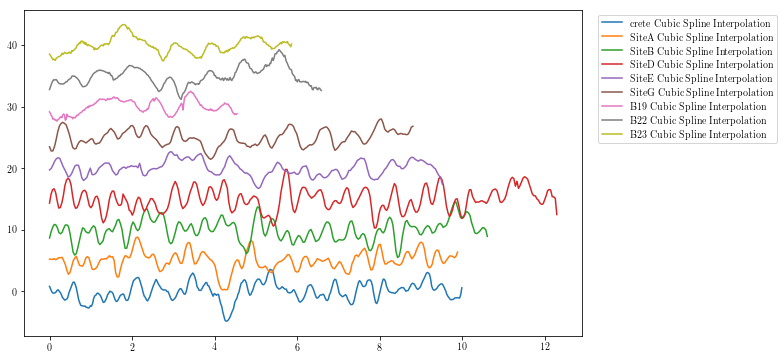

In [56]:
#valMin = 32.58#min(data['depth'])
#valMax = 37.12#max(data['depth'])
#import copy
#
#d_all = copy.deepcopy(data['depth'])
#x_all = copy.deepcopy(data['d18O'].copy())
#
#d = d_all[(d_all >= valMin) & (d_all <= valMax)]
#x = x_all[(d_all >= valMin) & (d_all <= valMax)]
#
#
#diff = np.diff(d)
#Delta = round(min(diff),3)
#
#d_min = Delta * np.ceil(d.values[0]/Delta)
#d_max = Delta * np.floor(d.values[-1]/Delta)
#
#n = int(1 + (d_max - d_min)/Delta)
#j_int = list(range(1,n))
#j_arr = np.linspace(1,n+1,n)
#dhat = d_min + (j_arr - 1)*Delta
#

from scipy import interpolate

def interpCores(valMin, valMax, d_in, x_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = round(min(diff), 3)
    
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(1,n+1,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat

fig, ax = plt.subplots(figsize=(10,6))
add = [0,5,10,15,20,25, 30, 35, 40]
for core, i in zip(CoreNames, range(len(CoreNames))):
    depthUse = AllData[core]['depth'] 
    d18OUse = AllData[core]['d18O']
    dhat, xhat = interpCores(valsMin[i], valsMax[i], depthUse, d18OUse)
    
    d18O_int = xhat - np.mean(xhat) + add[i]
    dep_int = dhat
    dep_int = dep_int - dep_int[0]
    
    d18O_U =  d18OUse[(depthUse >= valsMin[i]) & (depthUse <= valsMax[i])]#data['d18O'][(data['depth'] > valMin) & (data['depth'] < valMax)]
    d18O = d18O_U - np.mean(d18O_U) + add[i]
    dep = depthUse[(depthUse >= valsMin[i]) & (depthUse <= valsMax[i])]#data['depth'][(data['depth'] > valMin) & (data['depth'] < valMax)]
    dep = dep - dep.values[0]

#    ax.plot(dep, d18O, label=core + ' Data')
    ax.plot(dep_int, d18O_int, label=core + ' Cubic Spline Interpolation')
    ax.legend()
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
#ax.set(xlim=(min(valsMin), max(valsMax)));

In [35]:
AllData['SiteA']['depth'].values[1]

1.242

Interpolate with a cubic spline to get an evenly distributed signal

In [19]:
#from scipy import interpolate
#
#f = interpolate.CubicSpline(d,x)
#
#xhat = f(dhat)

In [20]:
#plt.plot(dhat,xhat)

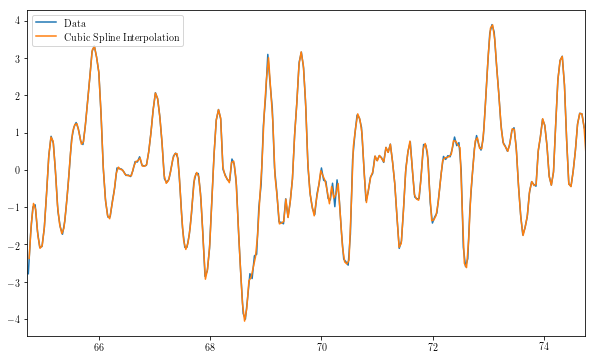

In [983]:
depth_in = np.asarray(dep_int)#s1[4]#
data_in = np.asarray(d18O_int)#s1[5]#
dt = depth_in[1] - depth_in[0]
N = data_in.size
sigma_in = 0.106

In [984]:
len(depth_in)

227

In [985]:
from Decon import SpectralDecon
decon_inst = SpectralDecon(depth_in, data_in, 2000)

In [986]:
a,b = decon_inst.plotSpectrum(showFig=False)


Using default boundaries for variance and a1
Diff. len., fit [cm]: 10.585


In [987]:
c,d =decon_inst.plotFilters(sigma=sigma_in, showFig=False)

Using default boundaries for variance and a1
Diff. len., fit [cm]: 10.585


In [988]:
e,f = decon_inst.plotDecon(sigma=sigma_in, showFig=False)

Using default boundaries for variance and a1
Diff. len., fit [cm]: 10.585


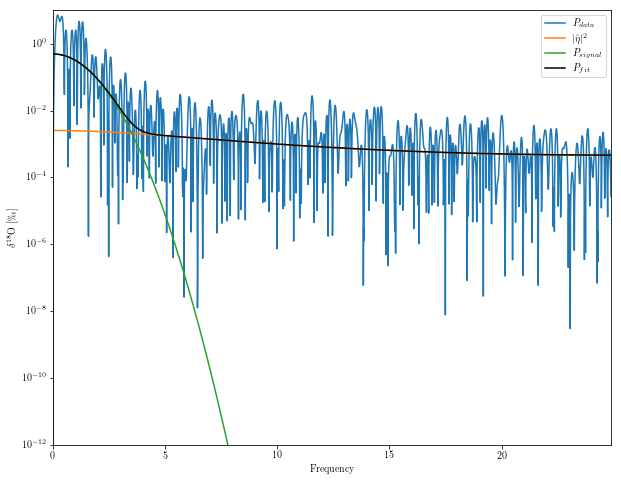

In [989]:
a

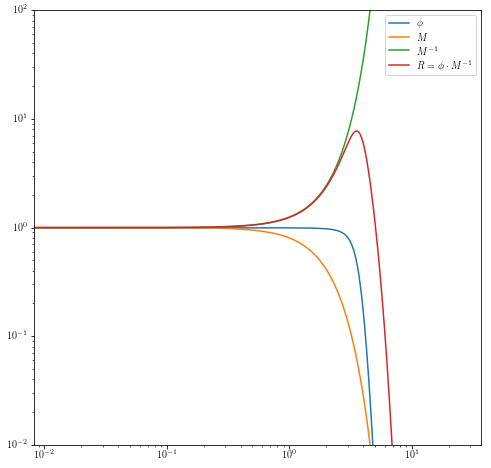

In [990]:
c

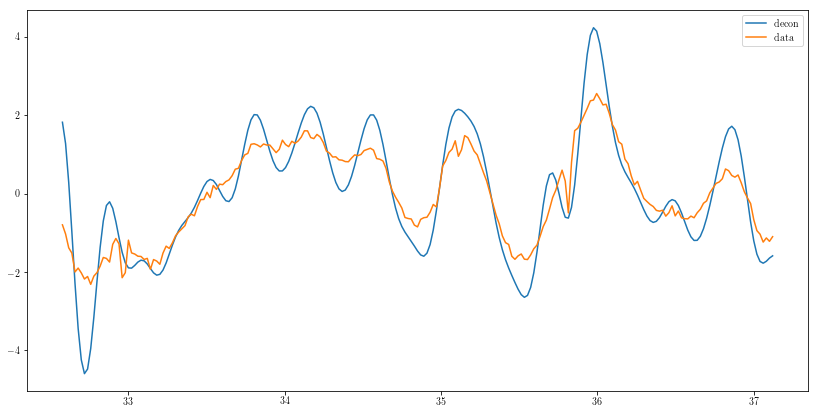

In [991]:
e

In [ ]:
len()

Generate a time series of synthetic data through an AR1 process:

In [2]:
#s1_instance = SyntheticData_Gen(AR1_coef = 0.3, AR1_var = 120, AR1_dt = 0.001, AR1_N = 20000, diff_len=0.08, dt_sample = 0.02, meas_noise = 0.03)
#s1 = s1_instance()

Plot said time series, both raw AR1 process and sampled/diffused series.

In [3]:
#plotFig = True
#if plotFig:
#    figSynth, axSynth = plt.subplots(figsize=(12,6))
#    axSynth.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]')
#    axSynth.plot(s1[2],s1[3],linewidth=0.8, color='blue', alpha=0.9,label='Before diffusion')
#    axSynth.plot(s1[4],s1[5], color='black', label='After diffusion')
#    axSynth.legend()
#    figSynth.savefig('SynthData.png')

Plot only the sampled/diffused data.

In [4]:
#if plotFig:
#    figSynthDiff, axSynthDiff = plt.subplots(figsize=(12,6))
#    axSynthDiff.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]', title='Synthetic data, after diffusion')
#    axSynthDiff.plot(s1[4],s1[5], color='black')
#